In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_b_corrupted import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [2]:
# SETUP WARPCORE
config_file = 'configs/finetune_b_3b_corrupted.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 4

warpcore = WurstCoreB(
    config_dict=loaded_config,
    device=device
)

In [3]:
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)
models = warpcore.setup_models(extras)
models.generator.bfloat16()
print("STAGE B READY")
pass

Training with batch size 4 (4/GPU)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


In [31]:
# models.generator.load_state_dict(load_or_fail("/weka/home-warp/models/wurstchen/B_exp3_finetuning_v2/base_100k.pt"))
models.generator.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_b_3b_finetuning_corrupted/generator_10k.safetensors"))


<All keys matched successfully>

ORIG SIZE: torch.Size([4, 3, 1024, 1024])


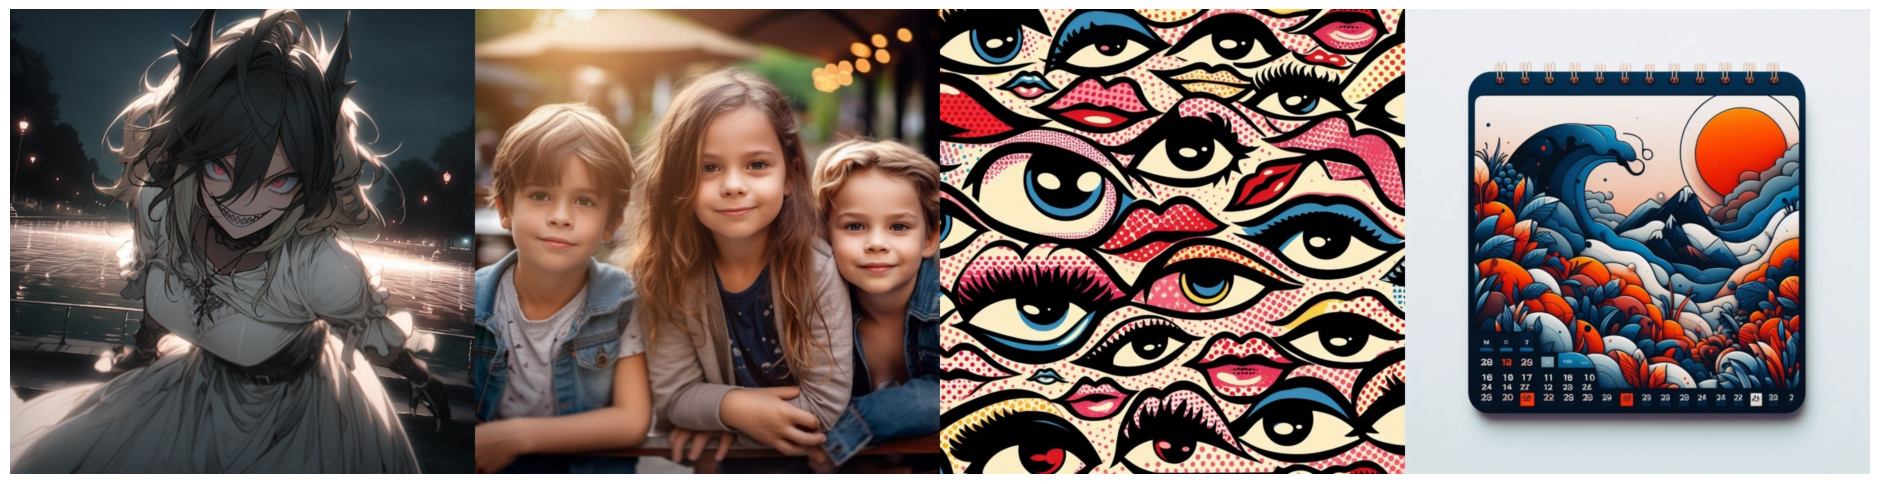

a female wearing a white dress, smiling creepily. She has black short hair and long brown curly hair, both of which are draped over her shoulders. Her red eyes show a deep sense of mystery and danger. there is a dark blue night sky behind her, with several streetlights along the sidewalk emitting faint yellow light. This creates a tranquil atmosphere in contrast to her eerie expression. Overall, this image gives people a spooky feeling and stimulates their imagination, making it difficult for them to stop looking at it.


In [23]:
# PREVIEW BATCH
batch = next(data.iterator)
print("ORIG SIZE:", batch['images'].shape)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'][0])

SCALED SIZE: torch.Size([4, 3, 768, 768])
torch.Size([4, 16, 24, 24])
torch.Size([4, 4, 256, 256]) torch.Size([4, 3, 1024, 1024])


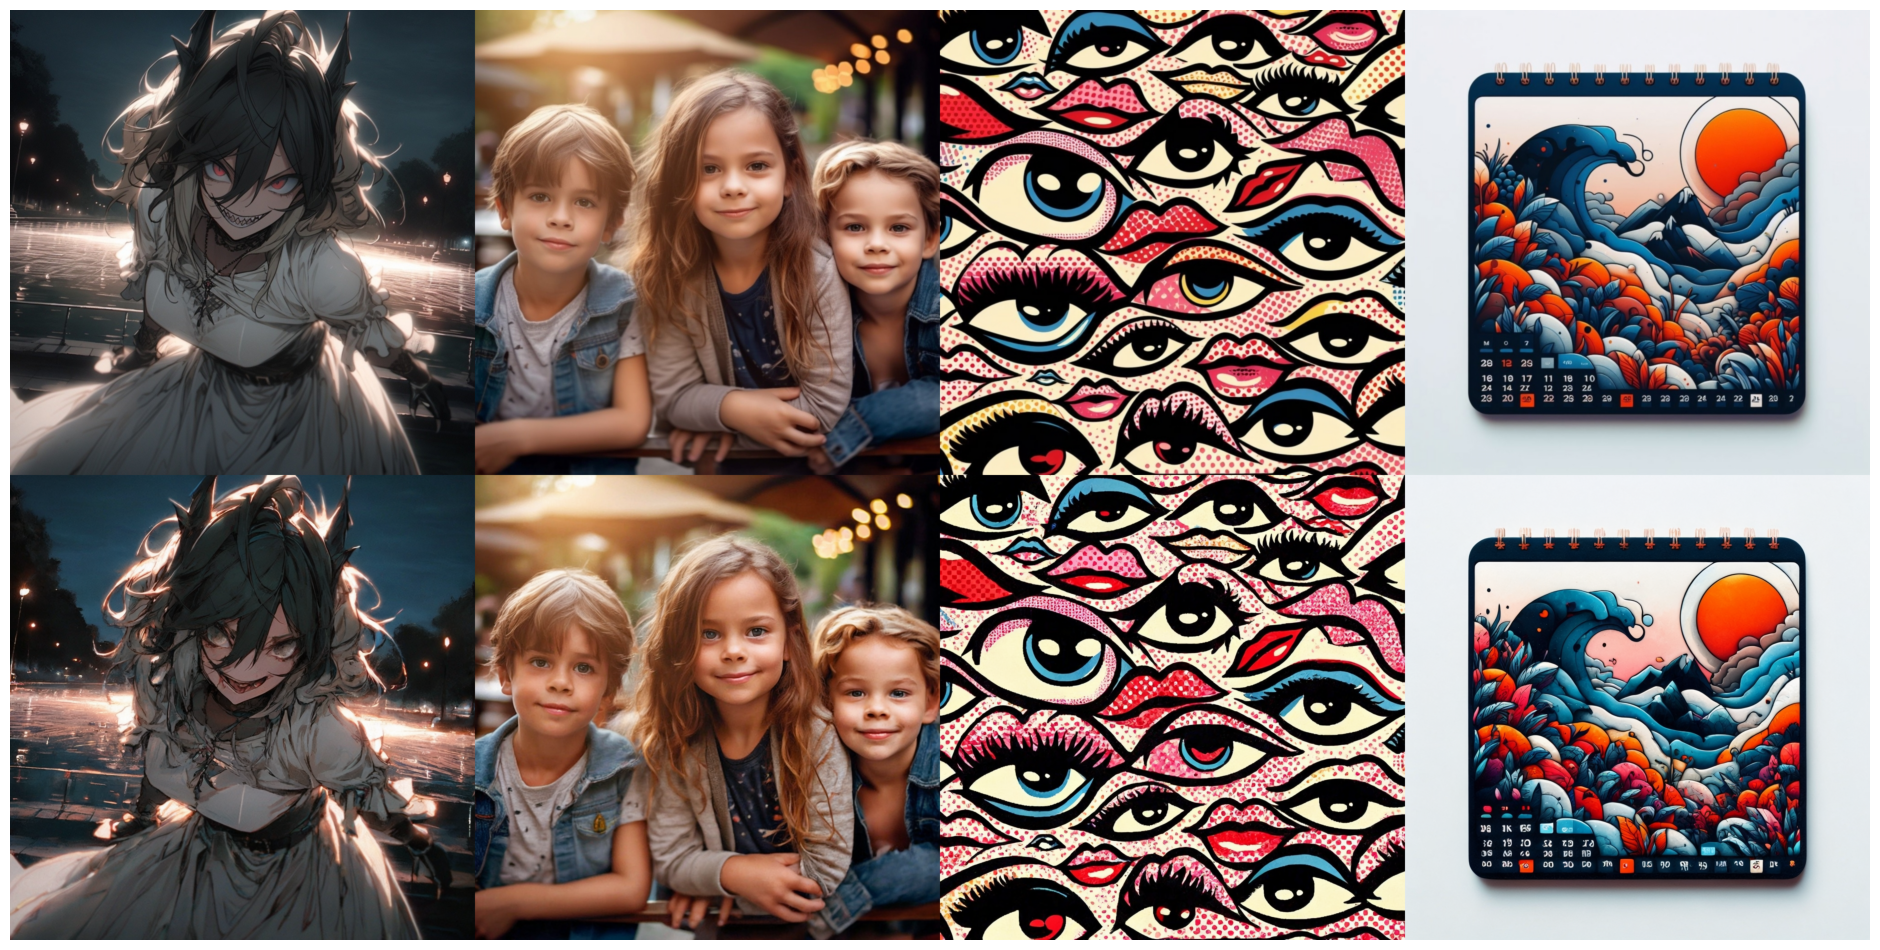

In [36]:
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    effnet_factor = 3/4
    effnet_height, effnet_width = int(((batch['images'].size(-2)*effnet_factor)//32)*32), int(((batch['images'].size(-1)*effnet_factor)//32)*32)
    scaled_image = torchvision.transforms.functional.resize(batch['images'], (effnet_height, effnet_width), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    print("SCALED SIZE:", scaled_image.shape)
    
    effnet_latents = models.effnet(extras.effnet_preprocess(scaled_image.to(device)))
    print(effnet_latents.shape)
    
    conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
    unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
    conditions['effnet'] = effnet_latents
    unconditions['effnet'] = torch.zeros_like(effnet_latents)

    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
        unconditions, device=device, **{**extras.sampling_configs, 'cfg': 1.5}
    )
    sampled_images = warpcore.decode_latents(sampled_latents, batch, models, extras).float().cpu()
    print(sampled_latents.shape, sampled_images.shape)
        
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_images.clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()
 
torchvision.utils.save_image(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_images.clamp(0, 1)], dim=-1),
], dim=-2), f'stage_b_test.jpg')
